In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Vector Area Zonal Stats Tutorial

> A basic introduction to Vector Area Zonal Stats 

## Basic Usage

Generate area zonal stats for a GeoDataframe containing areas of interest with a vector data source containing areas associated with statistics. 
> Note: the assumption for the data is that the statistics are uniformly distributed over the entire area for each row in the data source.


In [5]:
# hide
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geowrangler.area_zonal_stats as azs

In [7]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/simple_planar_aoi.geojson ] && curl -s -o ../data/simple_planar_aoi.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/simple_planar_aoi.geojson
![ ! -e ../data/simple_planar_data.geojson ] && curl -s -o ../data/simple_planar_data.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/simple_planar_data.geojson
![ ! -e ../data/region3_admin_grids.geojson ] && curl -s -o ../data/region3_admin_grids.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin_grids.geojson
![ ! -e ../data/region3_population_bgy_level.geojson ] && curl -s -o ../data/region3_population_bgy_level.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_population_bgy_level.geojson

### Simple Grid AOIs and Data

In [8]:
simple_aoi = gpd.read_file("../data/simple_planar_aoi.geojson")
simple_data = gpd.read_file("../data/simple_planar_data.geojson")

Given an aoi (`simple_aoi`) and geodataframe containing sample data (`simple_data`)

In [9]:
simple_aoi

,geometry
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00..."
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00..."
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00..."


In [10]:
simple_data

,population,internet_speed,geometry
0,100,20.0,"POLYGON ((0.250 0.000, 0.250 1.000, 1.250 1.00..."
1,200,10.0,"POLYGON ((1.250 0.000, 1.250 1.000, 2.250 1.00..."
2,300,5.0,"POLYGON ((2.250 0.000, 2.250 1.000, 3.250 1.00..."


In order correctly apportion the statistic, we need to make sure that the aoi and data geodataframes are using a `planar` CRS (i.e. `gdf.crs.is_geographic == False`)

In [12]:
simple_aoi.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
simple_data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

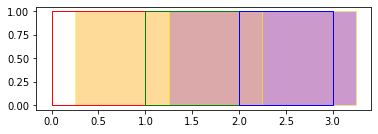

In [14]:
ax = plt.axes()
ax = simple_data.plot(
    ax=ax, color=["orange", "brown", "purple"], edgecolor="yellow", alpha=0.4
)
ax = simple_aoi.plot(ax=ax, facecolor="none", edgecolor=["r", "g", "b"])

The red,green,blue outlines are the 3 regions of interest (aoi) while the orange,brown, purple areas are the data areas. 

In [15]:
empty_aoi_results = azs.create_area_zonal_stats(simple_aoi, simple_data)

If no aggregations are specified, the `include_intersect=True` arg specifies that the sum of the data areas intersecting our aoi is computed in the column `intersect_area_sum`.  

In [16]:
empty_aoi_results

,geometry,intersect_area_sum
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",0.75
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",1.00
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",1.00


#### Apportioning aggregated statistics

To aggregate statistics over the aoi areas intersecting with the data areas, the default behavior of "apportioning" the statistic over the intersection of the data area overlapping the aoi area depends on the statistic.

* For `sum` it apportions the total value of the statistic over the proportion of the data area overlapping the aoi area divided by the total area of the _`data`_.
* For `mean` it apportions the total value of the statistic over the proportion of the data area overlapping the aoi area divided by the total area of the _`aoi`_.
* For other statistics, there is no apportioning done and uses the _`raw`_ statistics from the data areas overlapping the aoi area.

> Note: this default behavior can be overridden by specifying a prefix (`raw_`,`data_`,`aoi_`)  to the statistic (i.e. func) -- e.g. if you wish the apportion the `sum` as a proportion of the _aoi area_ instead of the _data area_, specify the func as `aoi_sum` instead of `sum`. 


In [17]:
%%time
simple_aoi_results = azs.create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func=["sum", "count"], column="population"),
        dict(func=["mean", "max", "min", "std"], column="internet_speed"),
    ],
)

CPU times: user 53.2 ms, sys: 728 µs, total: 53.9 ms
Wall time: 51.6 ms


In [18]:
simple_aoi_results

,geometry,intersect_area_sum,population_sum,population_count,internet_speed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",0.75,75.0,1,15.000,20.0,0.0,NaN
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",1.00,175.0,2,6.250,20.0,10.0,7.071068
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",1.00,275.0,2,3.125,10.0,5.0,3.535534


In [19]:
simple_aoi_results.population_sum.sum(axis=None)

525.0

Note the value of the mean of the internet speed for the 1st area above. 

While there is one data area overlapping with an internet speed of `20.0` the computed aggregate statistic for the mean is `15.0` due to the apportioning which only accounts for `0.75` (the total aoi area is `1.0`) -- meaning it assigns a value of `0.0` for the `0.25` area with no overlapping data area.

If you wish to override this behavior and impute the value of the statistic as the means of all the overlapping areas (in proportion to the overlap of their area over the total area of the aoi), you can additionally add a prefix of `imputed_` as shown in the next example. Note that adding a prefix doesn't change the default output column name, which is why we explicitly specified an output column name (`internet_speed_imputed_mean` in order to differentiate it from the original `internet_speed_mean` column.

Notice as well that adding a `raw_` prefix to the `min`,`max`,`std` statistics doesn't change their values since by default these statistics don't use any apportioning (so specifying `raw_` is redundant in this case).

Lastly, check the effect of setting of the `fix_min` arg to `False` (the default value is `True`) -- since it uses the _raw column_ to compute the `min`, it is not aware that there are areas in the aoi that have no overlapping data areas and uses the `min` value from the overlapping areas (in this case, since there is only 1 partially overlapping area, it uses that as the `min` value).  The `fix_min` arg "fixes" this by checking if the data areas completely overlap the aoi area and sets the minimum to `0`  if there is a portion of the aoi area that is not completely intersected by a data area.


In [31]:
%%time
corrected_aoi_results = azs.create_area_zonal_stats(
    simple_aoi,
    simple_data,
    [
        dict(func=["sum", "count"], column="population"),
        dict(
            func=["mean", "imputed_mean", "raw_max", "raw_min", "raw_std"],
            column="internet_speed",
            output=[
                "internet_speed_mean",
                "internet_speed_imputed_mean",
                "internet_speed_max",
                "internet_speed_min",
                "internet_speed_std",
            ],
        ),
    ],
    fix_min=False,
)

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 101 ms


In [32]:
corrected_aoi_results

,geometry,intersect_area_sum,population_sum,population_count,internet_speed_mean,internet_speed_imputed_mean,internet_speed_max,internet_speed_min,internet_speed_std
0,"POLYGON ((0.000 0.000, 0.000 1.000, 1.000 1.00...",0.75,75.0,1,15.000,20.000,20.0,20.0,NaN
1,"POLYGON ((1.000 0.000, 1.000 1.000, 2.000 1.00...",1.00,175.0,2,6.250,6.250,20.0,10.0,7.071068
2,"POLYGON ((2.000 0.000, 2.000 1.000, 3.000 1.00...",1.00,275.0,2,3.125,3.125,10.0,5.0,3.535534


### Custom Grids over admin area data

> Another example using aggregated statistics over admin areas (barangay level) that are apportioned into grid areas by their overlap.


> Notice that since the grid areas does not completely overlap the admin areas (and vice versa) , the sum of their total populations and land areas are not equal.

In [33]:
%%time
region3_admin_grids = gpd.read_file("../data/region3_admin_grids.geojson")
region3_admin_grids = region3_admin_grids.to_crs("EPSG:3857")  # convert to planar

CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 157 ms


In [34]:
%%time
region3_pop_bgy_level = gpd.read_file("../data/region3_population_bgy_level.geojson")

CPU times: user 376 ms, sys: 29.2 ms, total: 405 ms
Wall time: 402 ms


In [35]:
%%time
aoi_result = azs.create_area_zonal_stats(
    region3_admin_grids,
    region3_pop_bgy_level,
    [
        dict(func=["sum", "count"], column="population"),
    ],
)

CPU times: user 764 ms, sys: 0 ns, total: 764 ms
Wall time: 763 ms


In [36]:
aoi_result

,x,y,geometry,intersect_area_sum,population_sum,population_count
0,0,30,"POLYGON ((13334497.956 1771012.807, 13339497.9...",1.213773e+06,687.832840,1
1,0,31,"POLYGON ((13334497.956 1776012.807, 13339497.9...",2.471924e+06,986.890853,1
2,0,32,"POLYGON ((13334497.956 1781012.807, 13339497.9...",2.748813e+06,1097.435840,1
3,1,30,"POLYGON ((13339497.956 1771012.807, 13344497.9...",1.081669e+06,468.368614,2
4,1,32,"POLYGON ((13339497.956 1781012.807, 13344497.9...",8.941593e+04,8.570604,2
...,...,...,...,...,...,...
1069,54,44,"POLYGON ((13604497.956 1841012.807, 13609497.9...",1.976718e+05,15.398162,1
1070,54,45,"POLYGON ((13604497.956 1846012.807, 13609497.9...",1.019141e+07,1613.913393,3
1071,54,46,"POLYGON ((13604497.956 1851012.807, 13609497.9...",3.129991e+06,1033.997979,2
1072,54,47,"POLYGON ((13604497.956 1856012.807, 13609497.9...",8.106461e+06,250.893691,2


In [44]:
(
    aoi_result.geometry.area.sum(),
    aoi_result.intersect_area_sum.sum(),
    aoi_result.population_sum.sum(),
)

(26850000000.000072, 24548892214.947075, 12136963.9717533)

In [43]:
(region3_pop_bgy_level.geometry.area.sum(), region3_pop_bgy_level.population.sum())

(27658006631.682587, 13139695)

In [37]:
gdf = region3_admin_grids
gdf2 = region3_pop_bgy_level

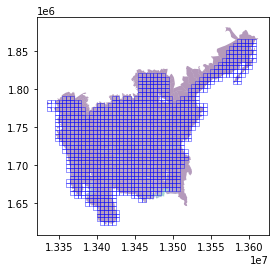

In [38]:
ax = plt.axes()
ax = gdf2.plot(ax=ax, column="population", alpha=0.4)
ax = gdf.plot(ax=ax, facecolor="none", edgecolor="blue", alpha=0.4)

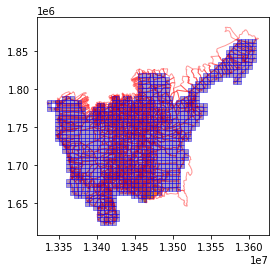

In [39]:
ax = plt.axes()
ax = gdf2.plot(ax=ax, facecolor="none", alpha=0.4, edgecolor="red")
ax = aoi_result.plot(column="population_sum", ax=ax, alpha=0.4, edgecolor="blue")

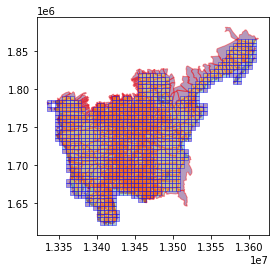

In [40]:
ax = plt.axes()
ax = gdf2.plot(ax=ax, column="population", alpha=0.4, edgecolor="red")
ax = aoi_result.plot(column="intersect_area_sum", ax=ax, alpha=0.4, edgecolor="blue")